In [28]:
!pip install natsort --user

In [1]:
import pickle
import yaml
from pathlib import Path

import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt

## 各モデルの性能比較

In [12]:
def load_log_data(model_dir):
    filename = Path(model_dir, "each_r2_score.yaml")
    with open(filename, "r") as f:
        score = yaml.safe_load(f)
    filename = Path(model_dir, "broken_columns.pkl")
    with open(filename, "rb") as f:
        broken_cols = pickle.load(f)
    filename = Path(model_dir, ".hydra/overrides.yaml")
    with open(filename, "r") as f:
        params = yaml.safe_load(f)
    return score, broken_cols, params

In [13]:
model_dir = "../output/exp135a/run0/"
s1, brokne_cols1, p1 = load_log_data(model_dir)
brokne_cols1, p1

(array(['ptend_q0003_15'], dtype='<U14'),
 ['model=light_cnn_model_v2',
  'trainer.max_epochs=5',
  'trainer.devices=[0]',
  'optimizer.params.lr=0.001',
  'batch_size=512',
  'dataset_name=dataset_v9',
  'exp_name=exp135a',
  'model.params.use_in_aux=True',
  'model.params.out_channels=256',
  'model.params.num_layers=7',
  'model.params.conv_expand=4'])

In [14]:
model_dir = "../output/exp121a/run0/"
s2, brokne_cols2, p2 = load_log_data(model_dir)
brokne_cols2, p2

(array([], dtype='<U14'),
 ['model=aslfr_model',
  'trainer.max_epochs=5',
  'trainer.devices=[1]',
  'optimizer.params.lr=0.001',
  'batch_size=512',
  'exp_name=exp121a',
  'dataset_name=dataset_v6',
  'model.params.dims=256',
  'model.params.num_layers=5',
  'model.params.conv_expand=4',
  'model.params.attn_expand=4'])

In [15]:
def get_x_y(s):
    x, y = [], []
    for k, v in s.items():
        x.append(k)
        y.append(max(v, -1))
    x, y = zip(*natsorted(zip(x, y), lambda x: x[0]))
    return x, y


x1, y1 = get_x_y(s1)
x2, y2 = get_x_y(s2)

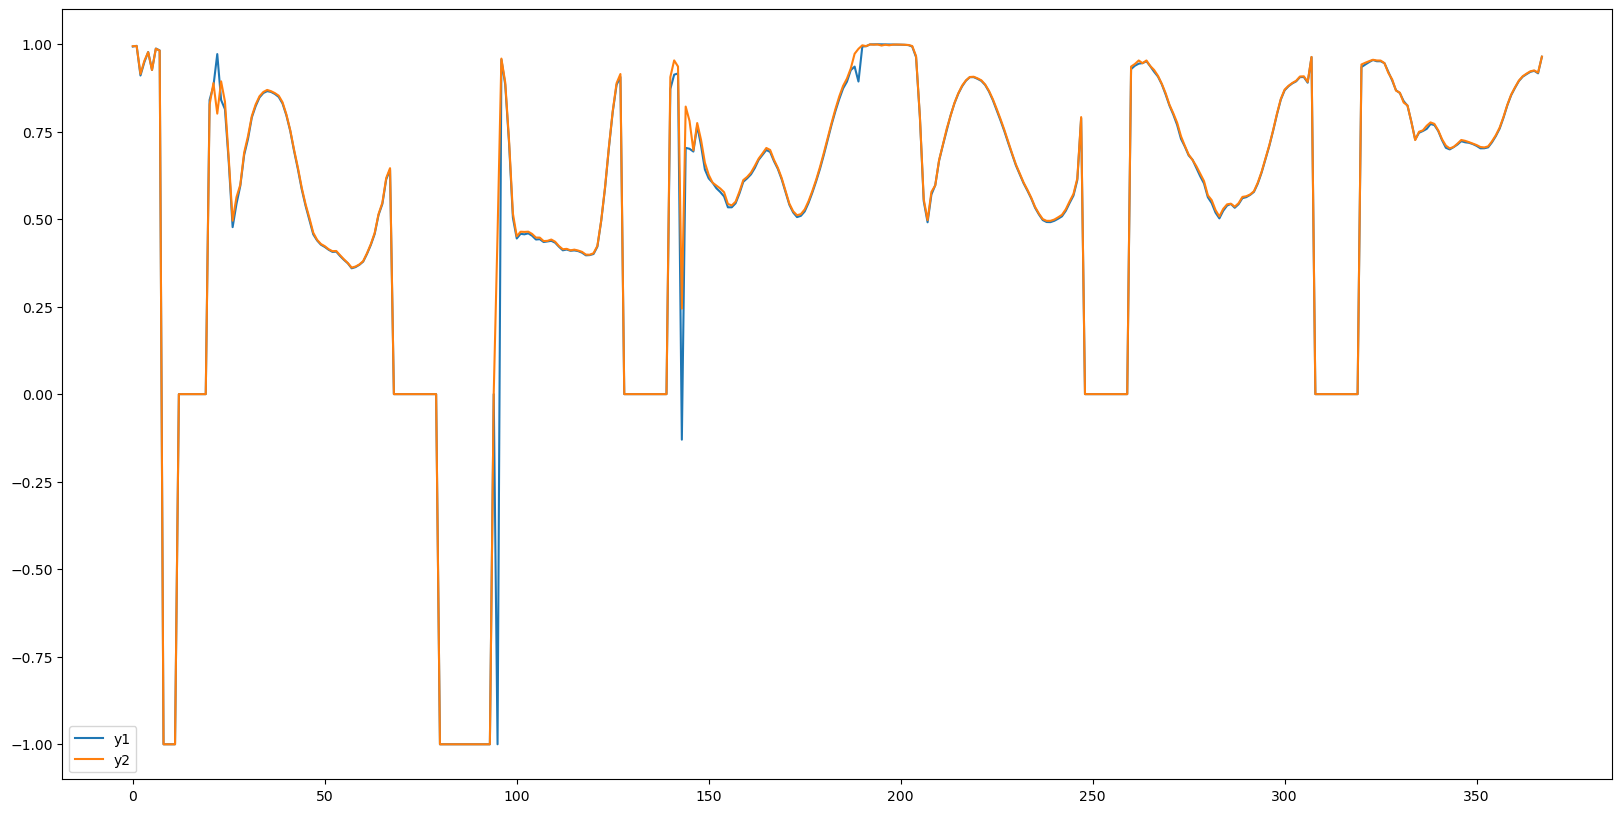

In [16]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(y1)), y1, label="y1")
plt.plot(np.arange(len(y1)), y2, label="y2")
plt.legend()

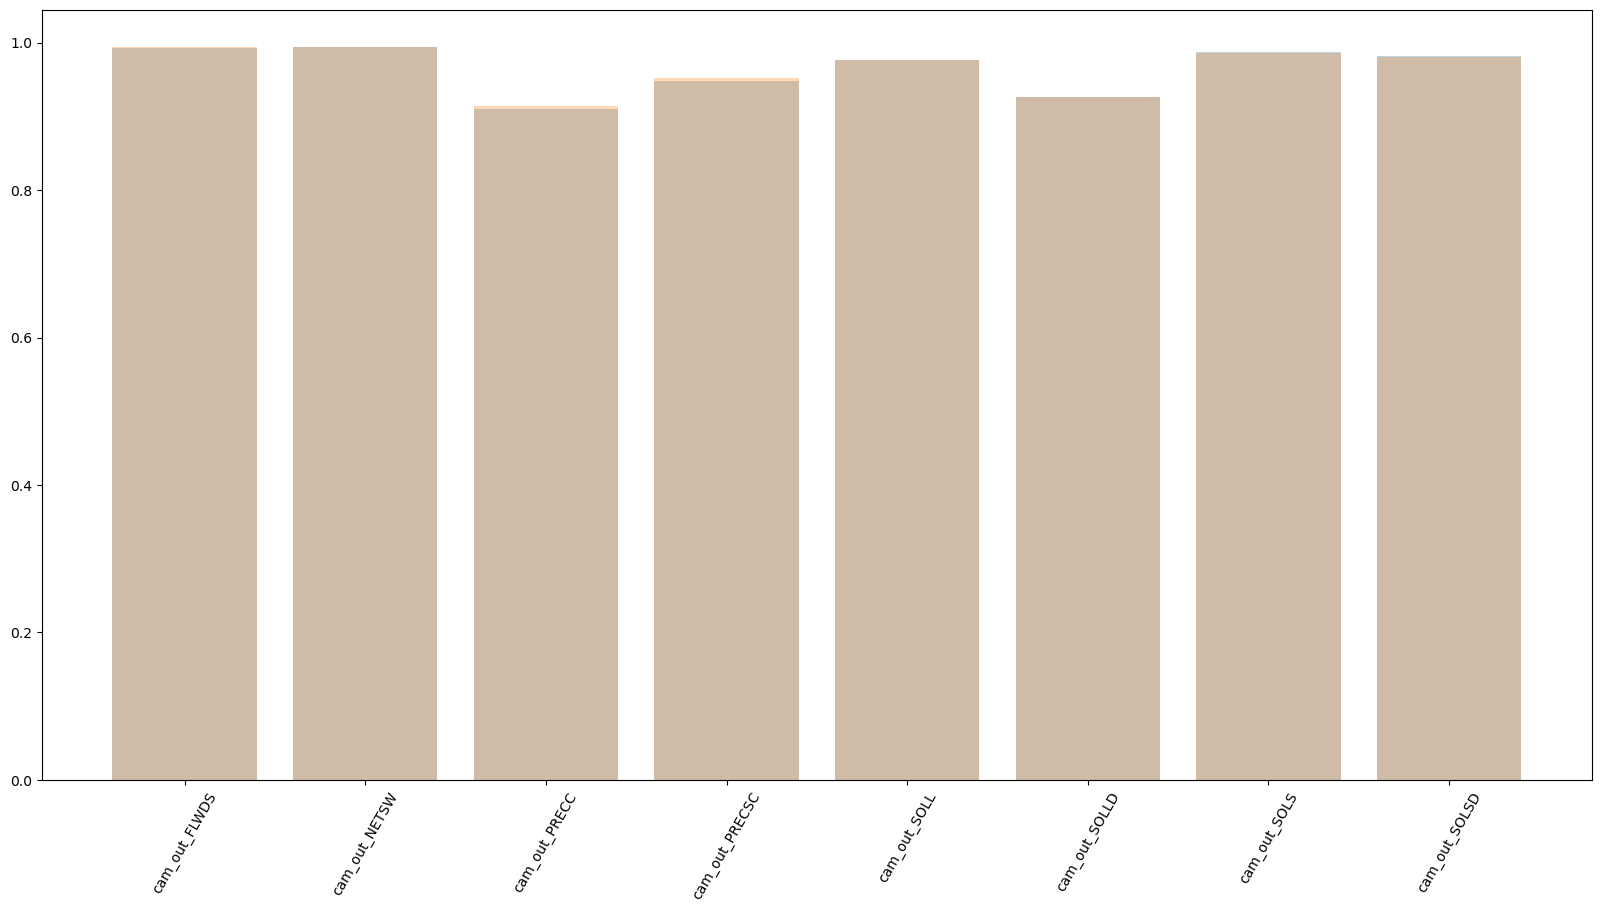

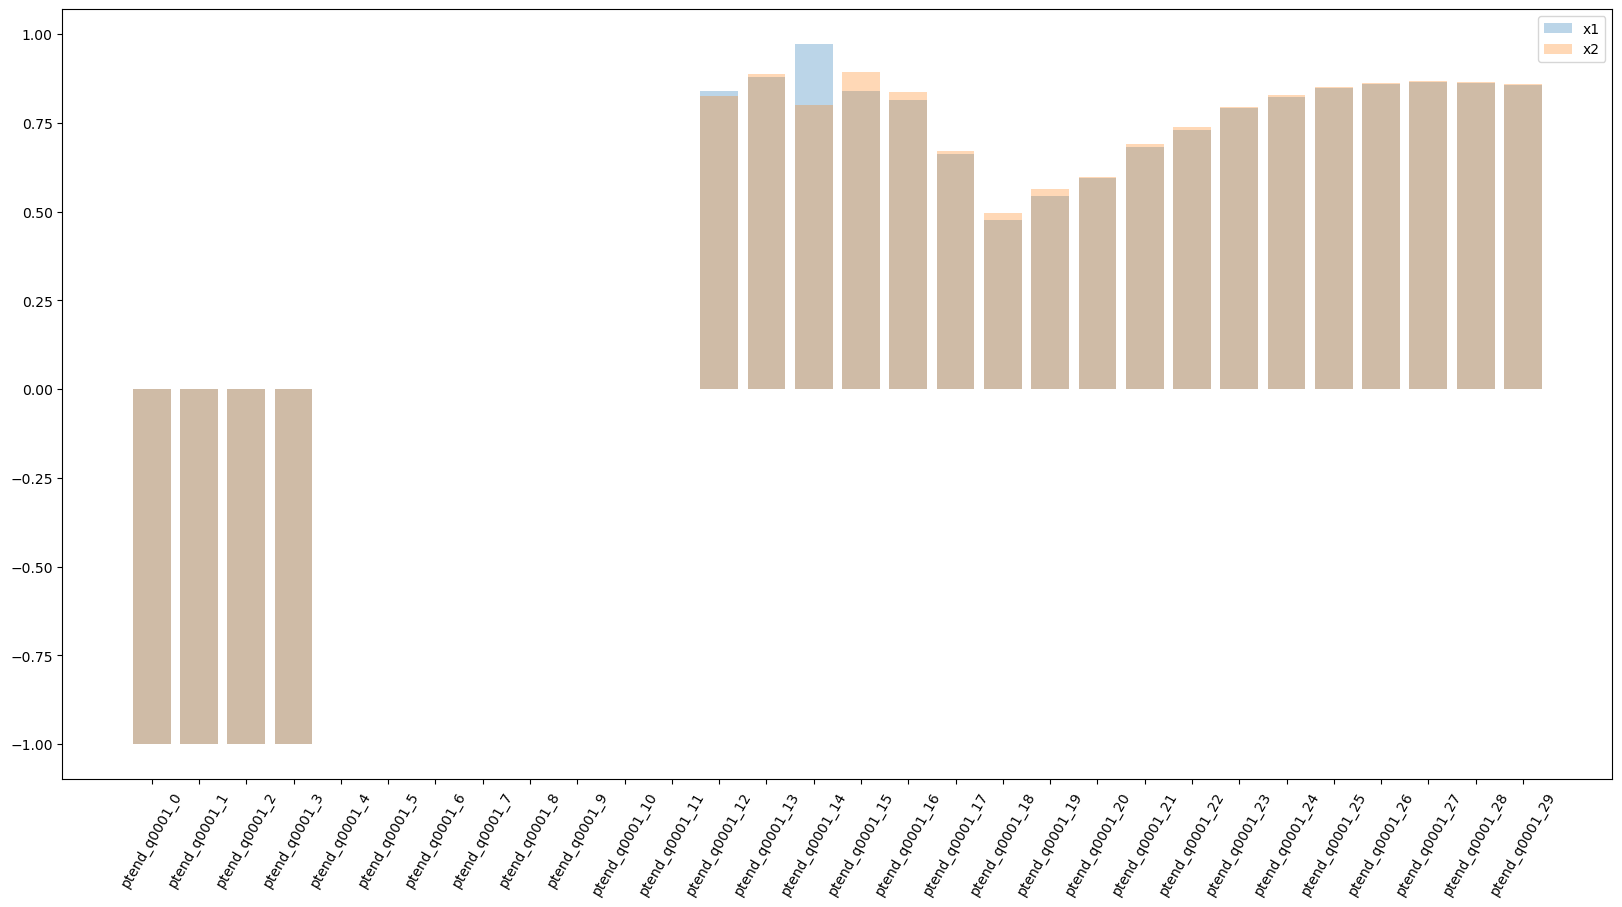

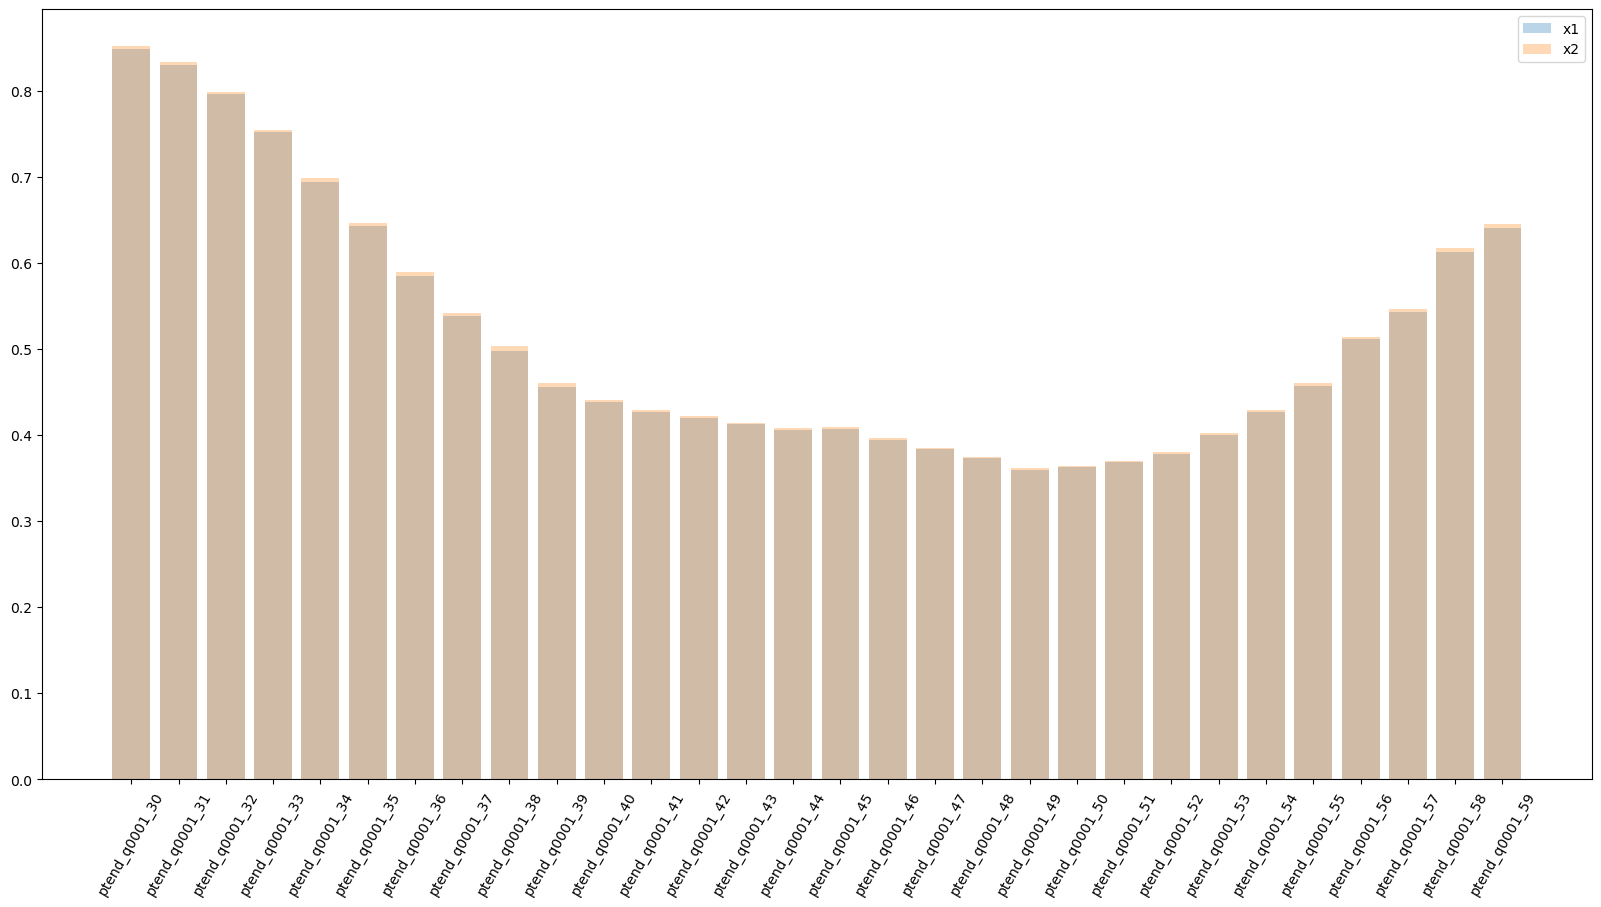

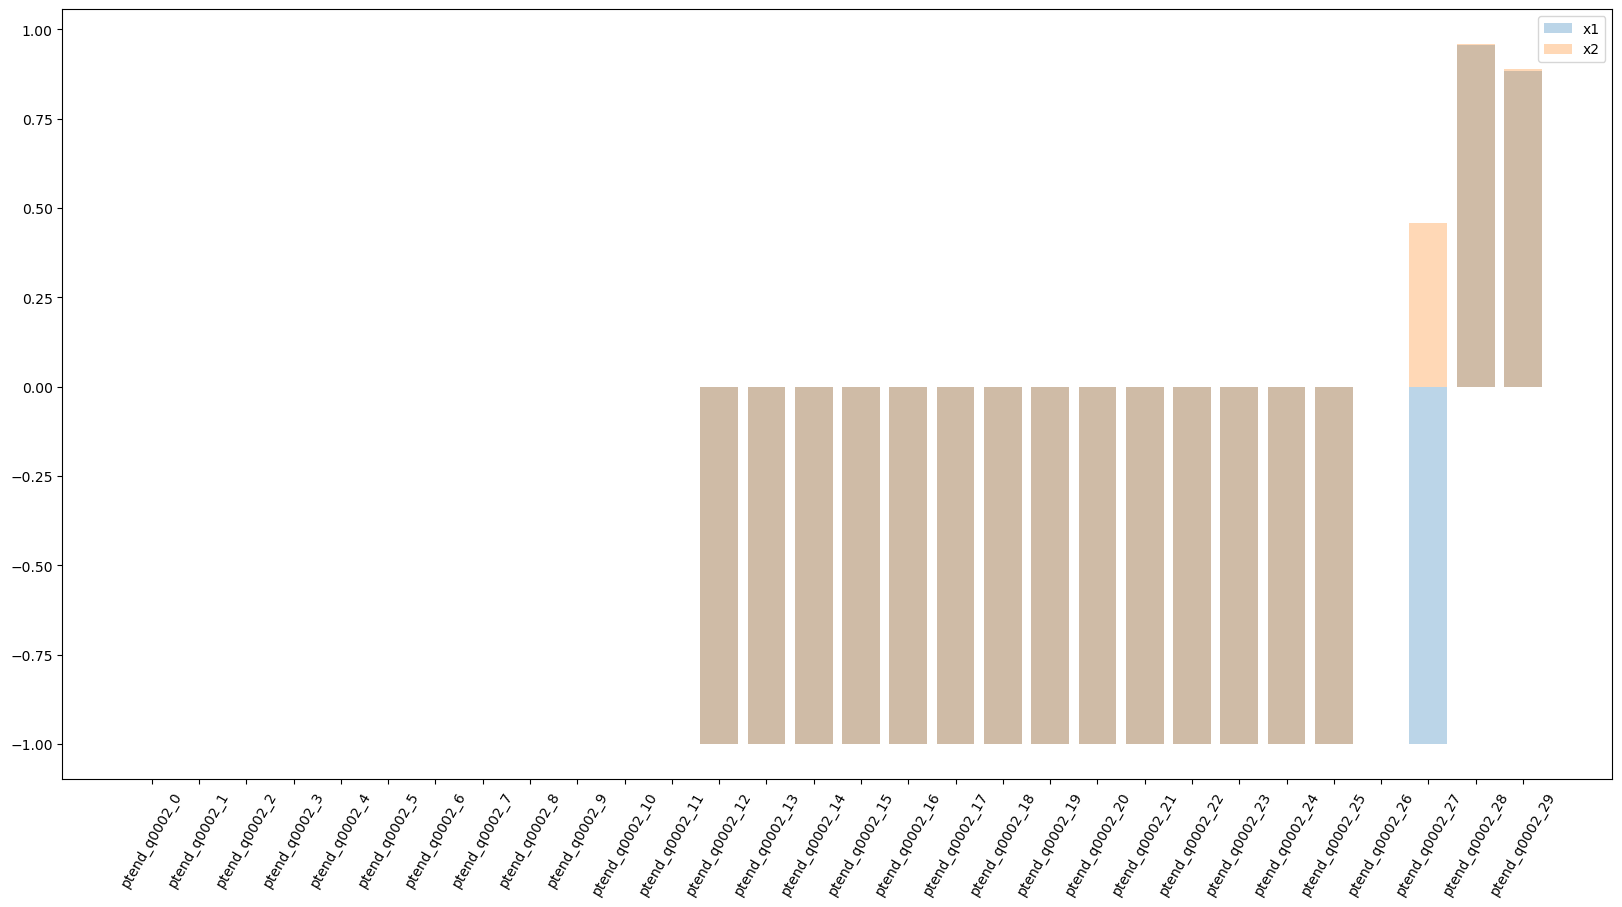

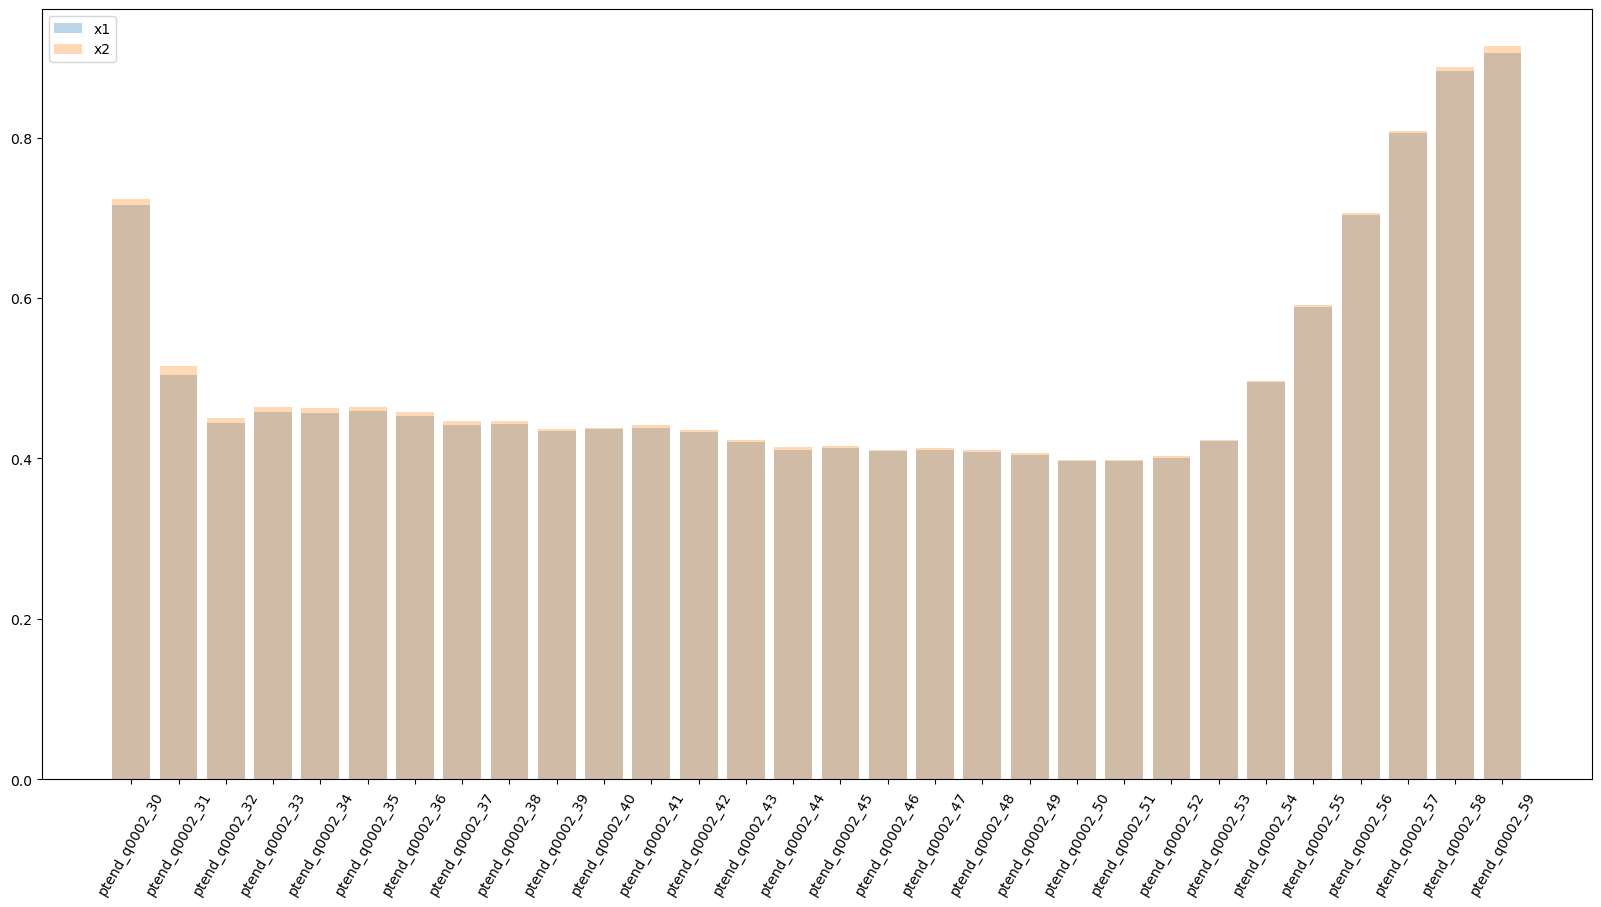

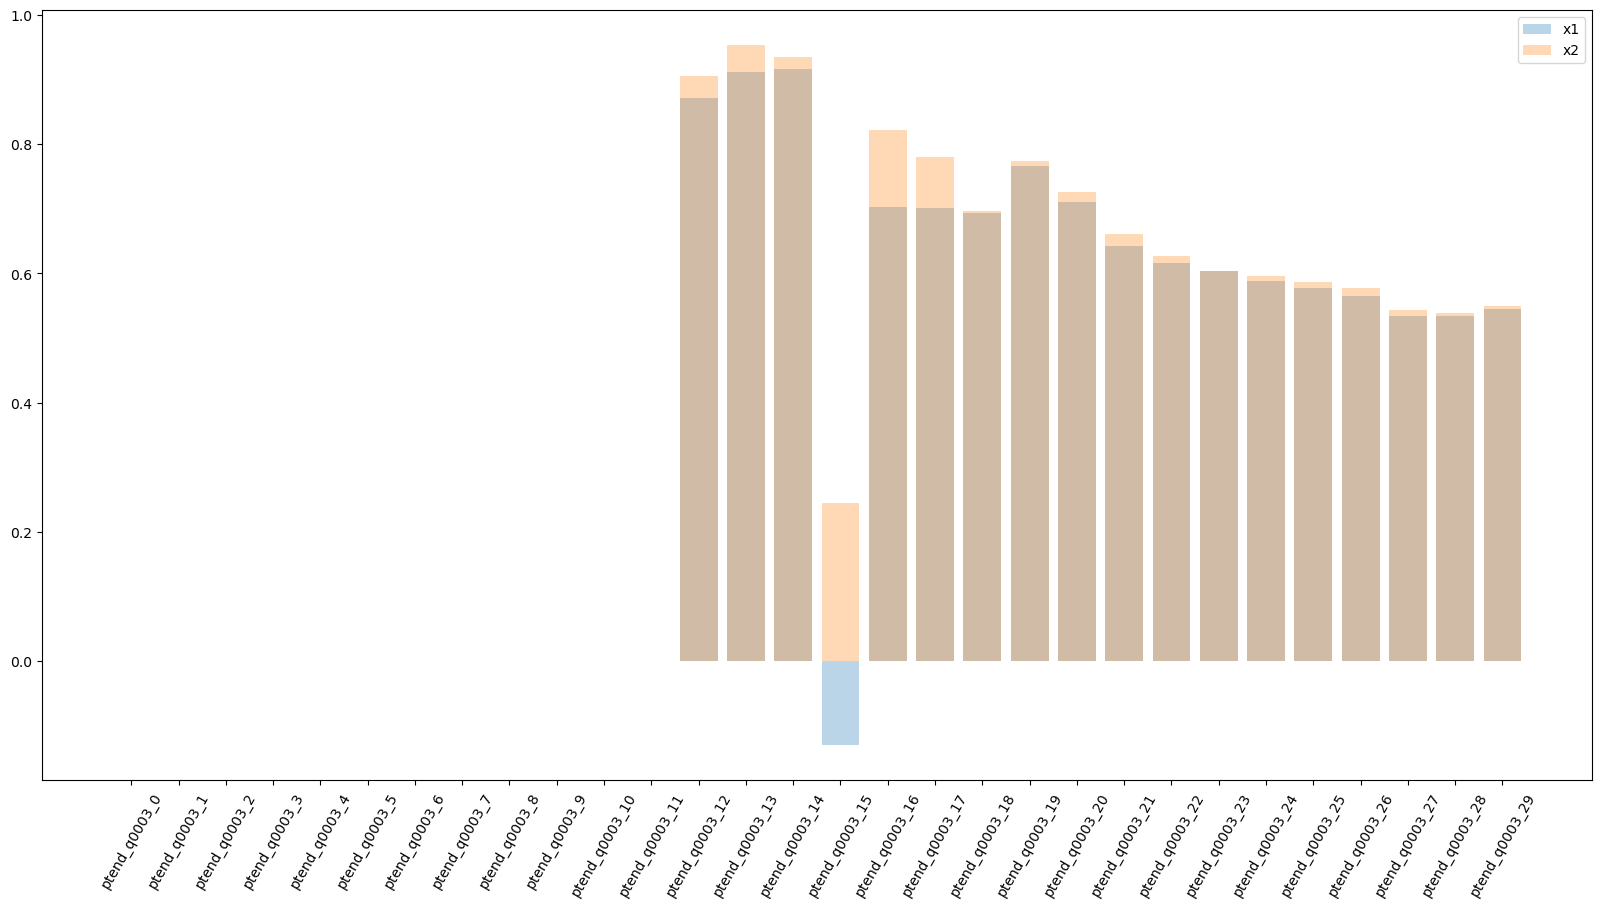

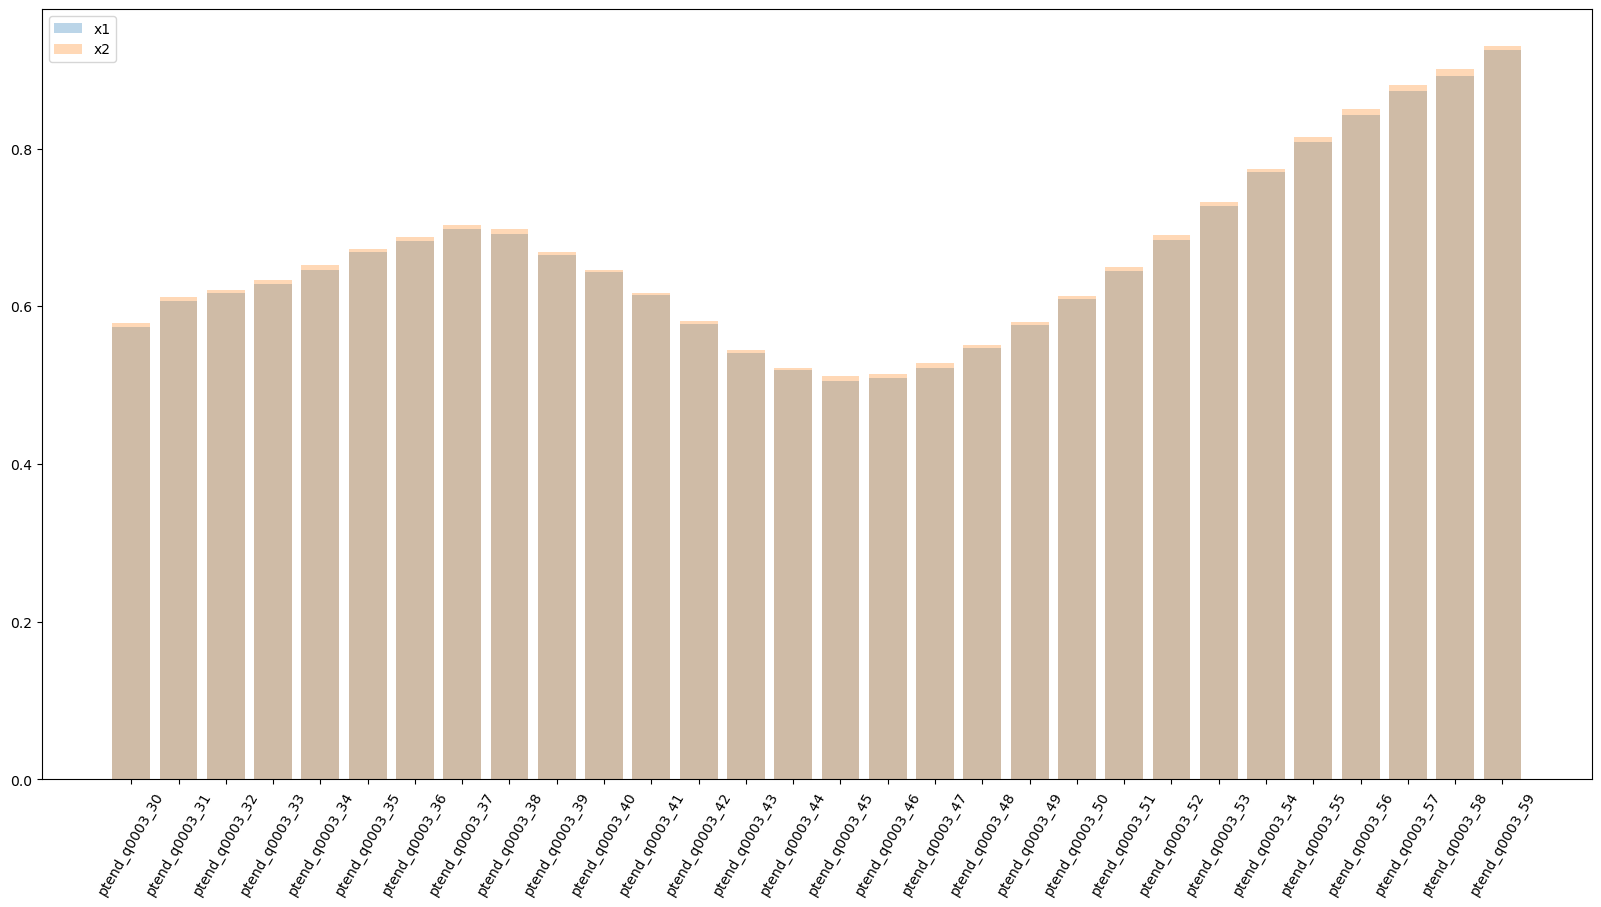

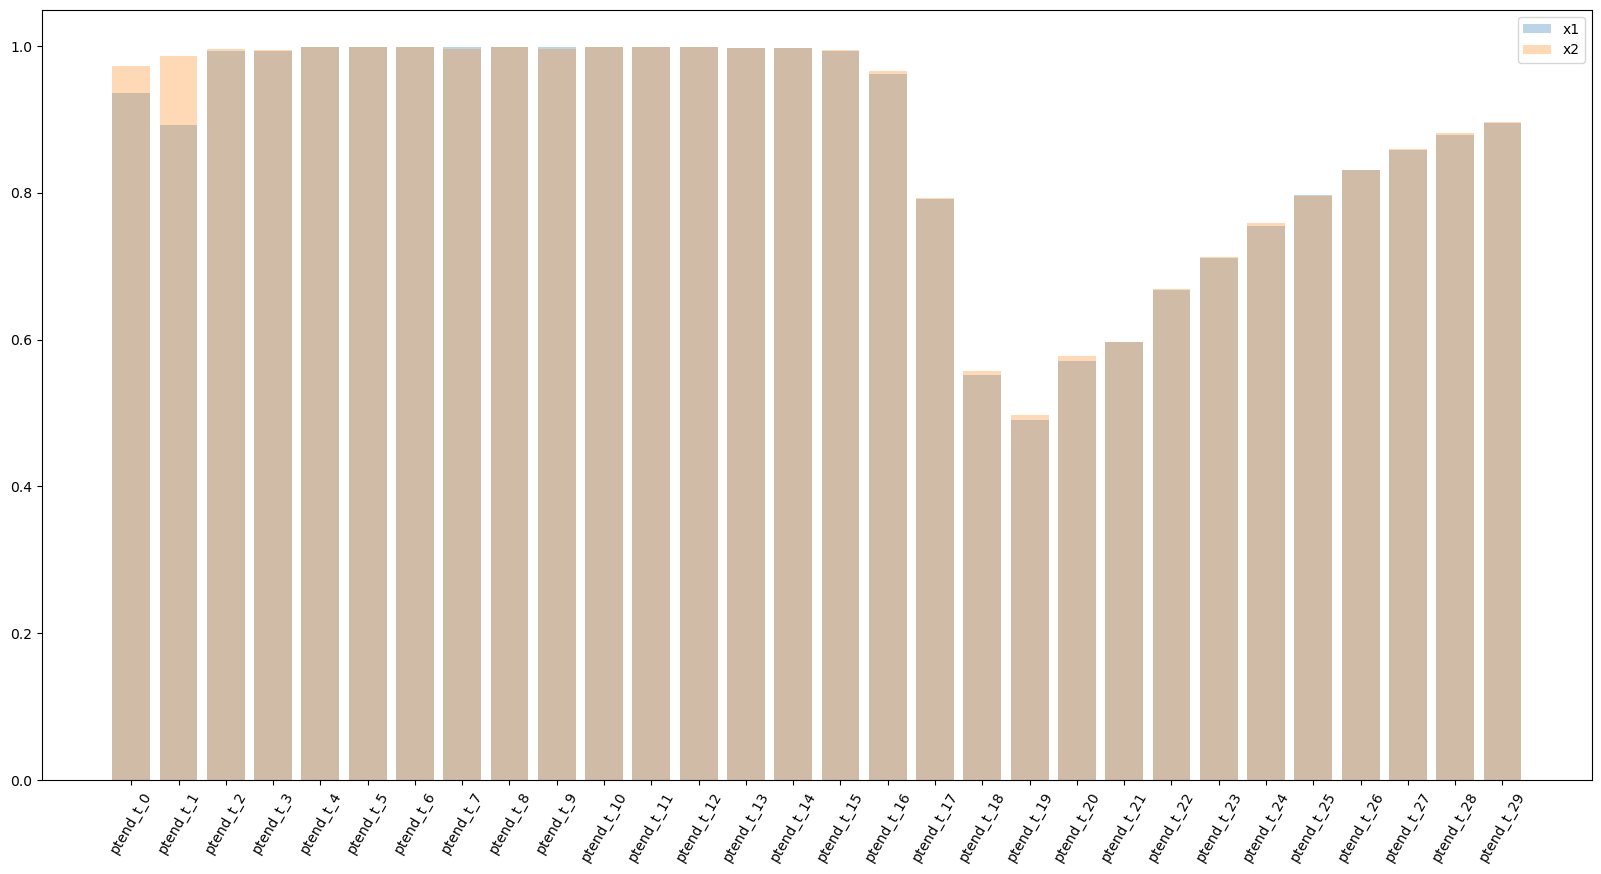

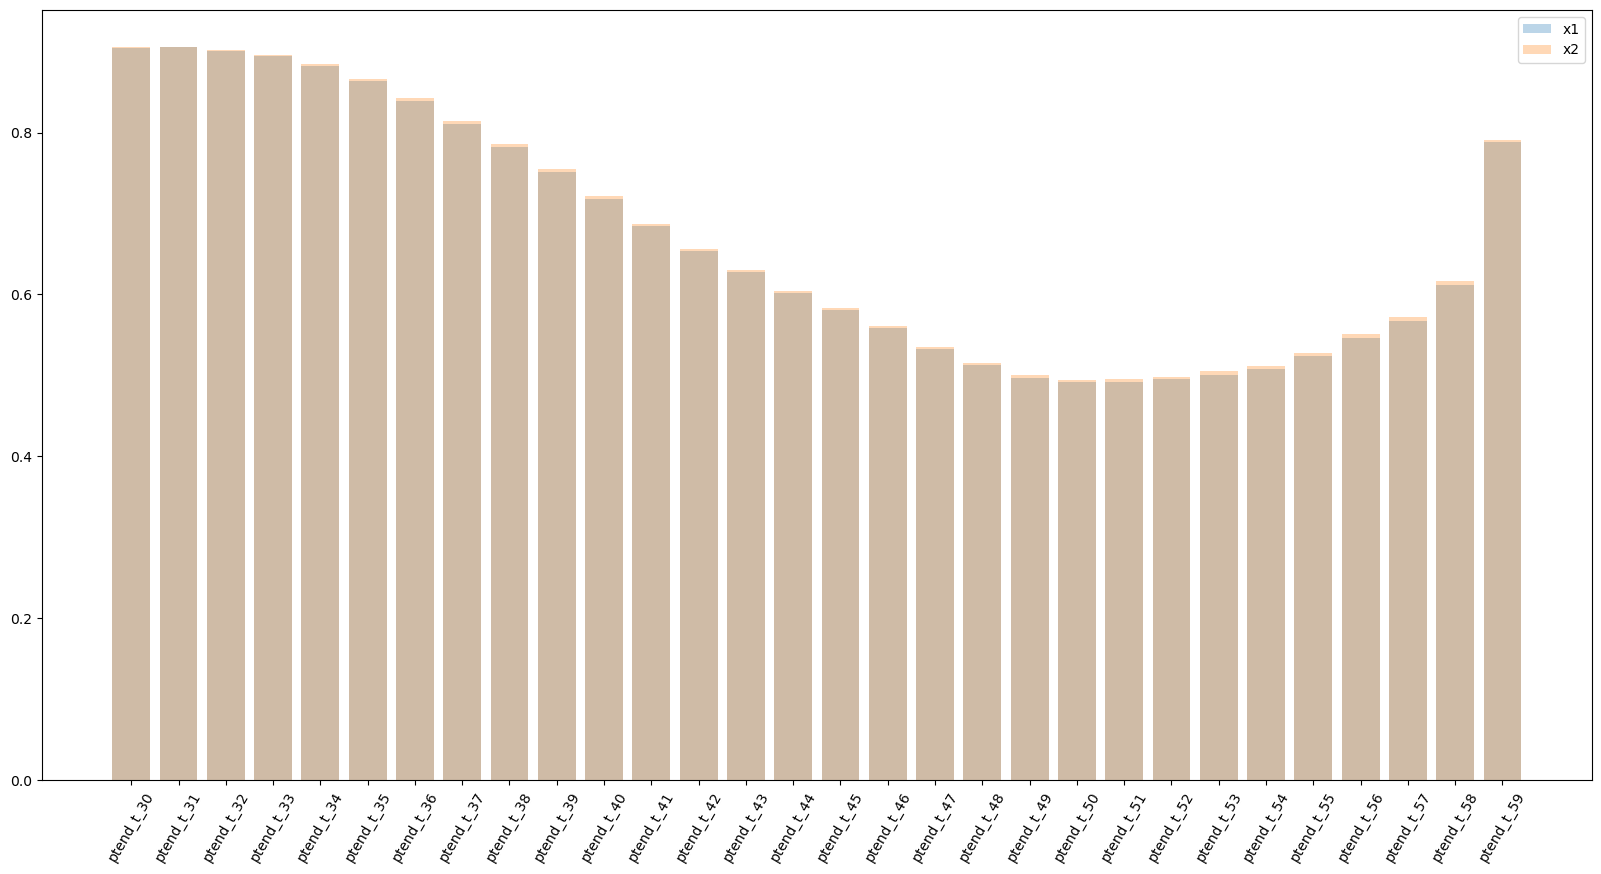

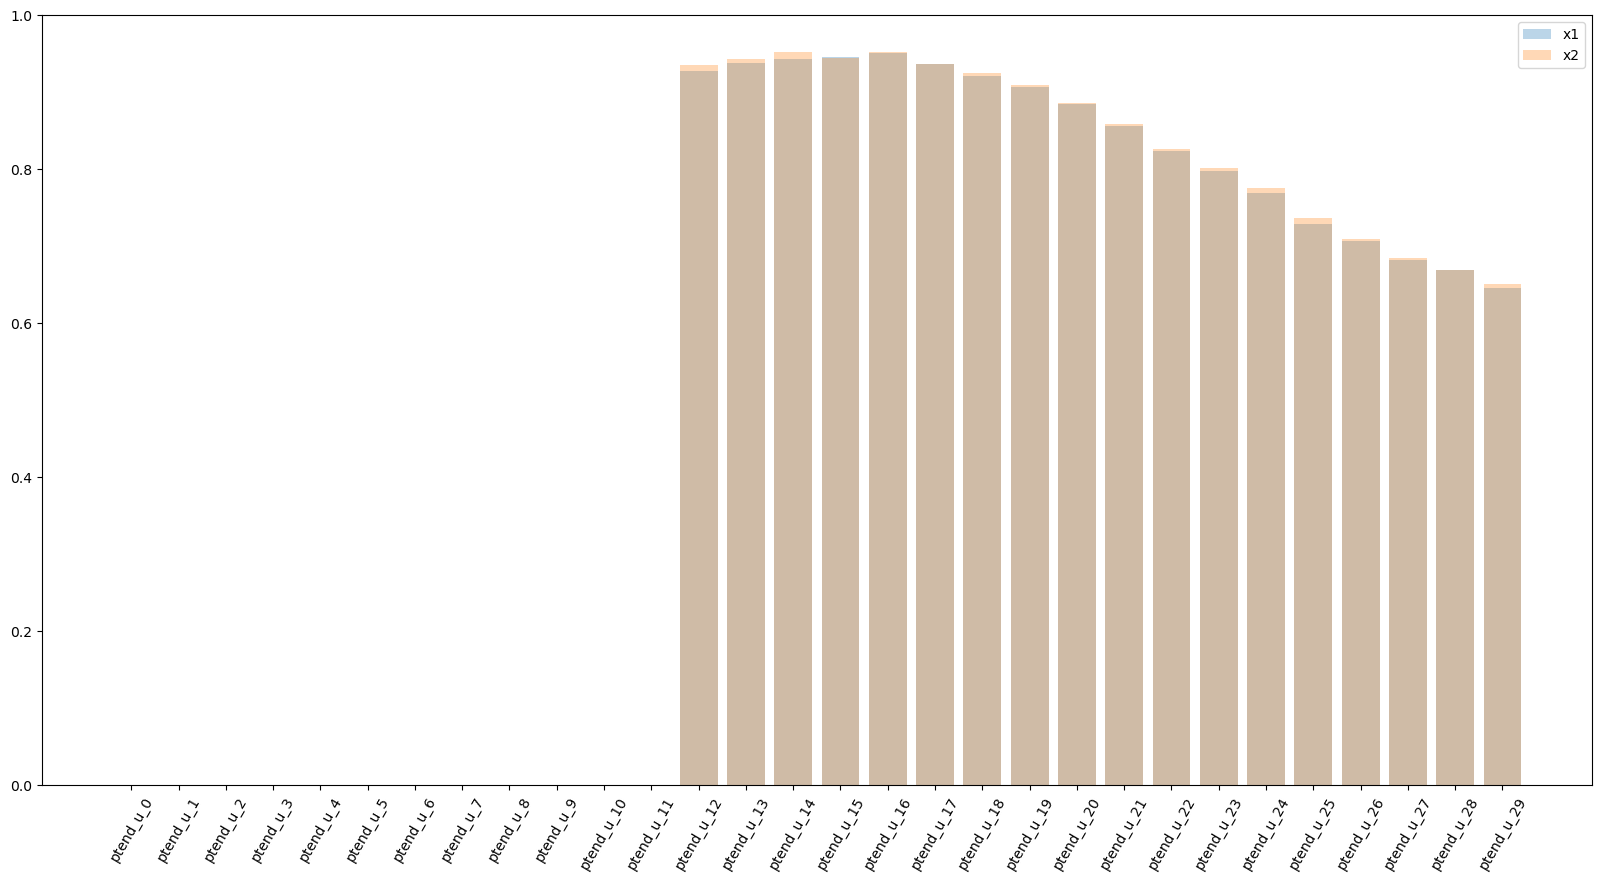

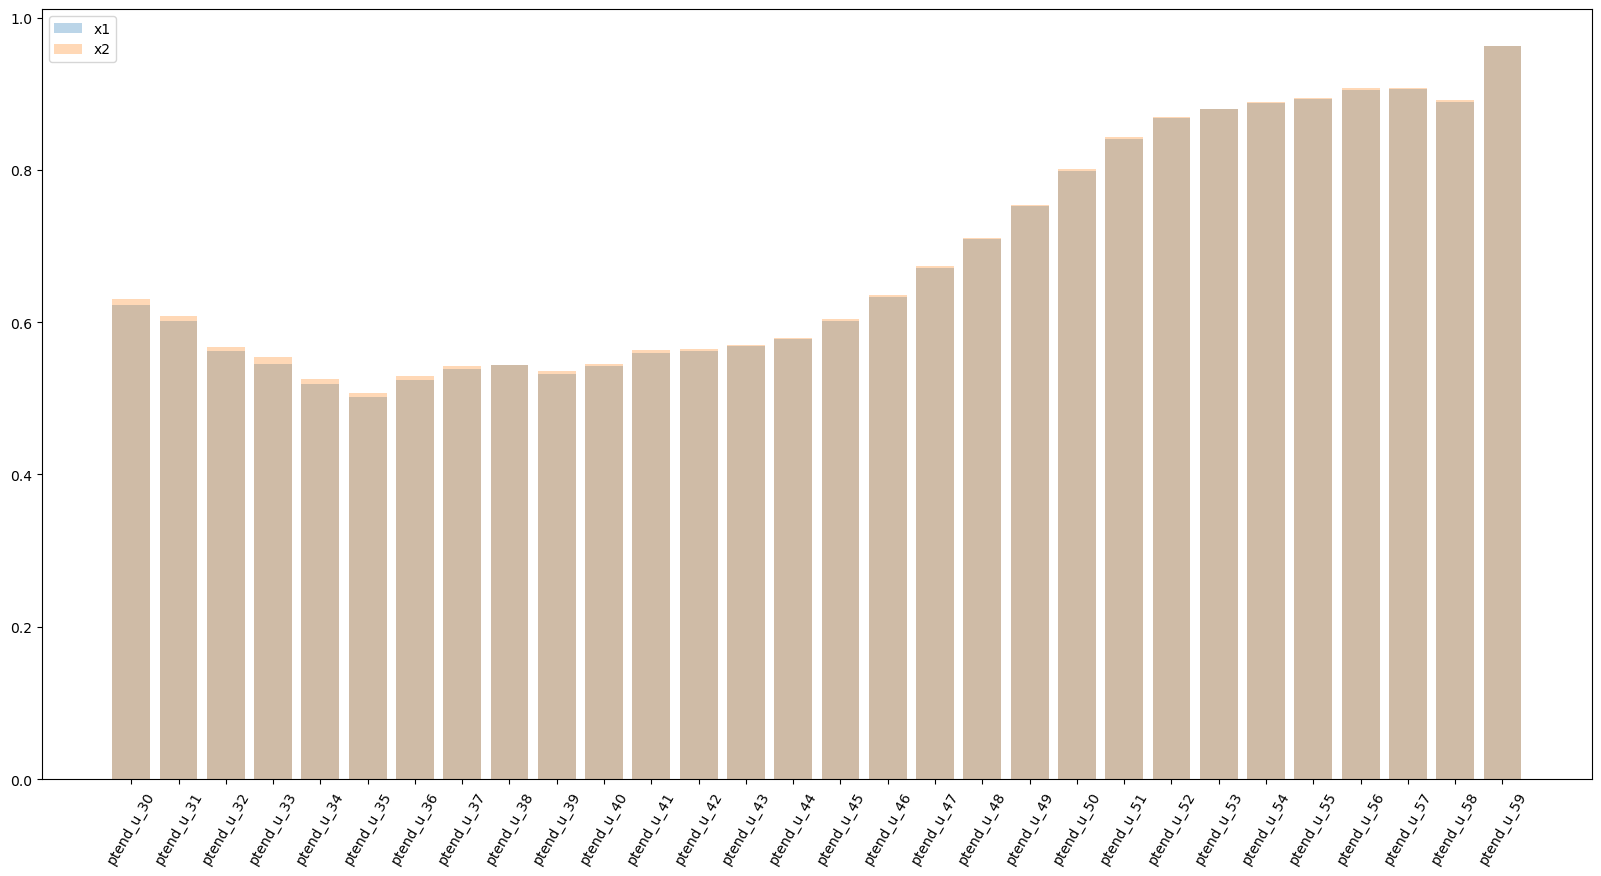

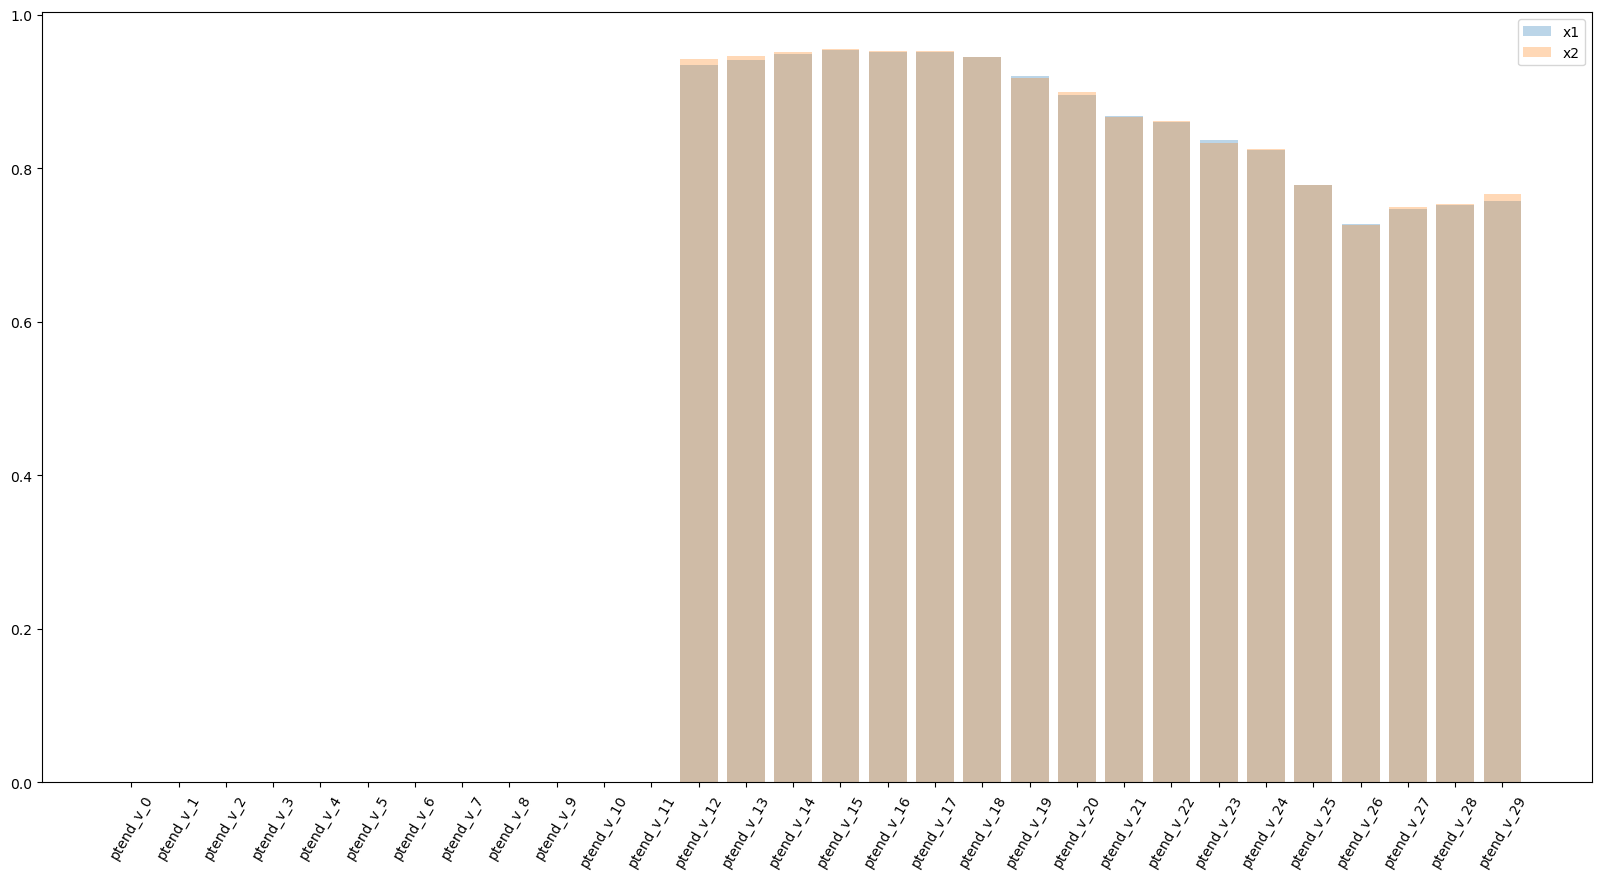

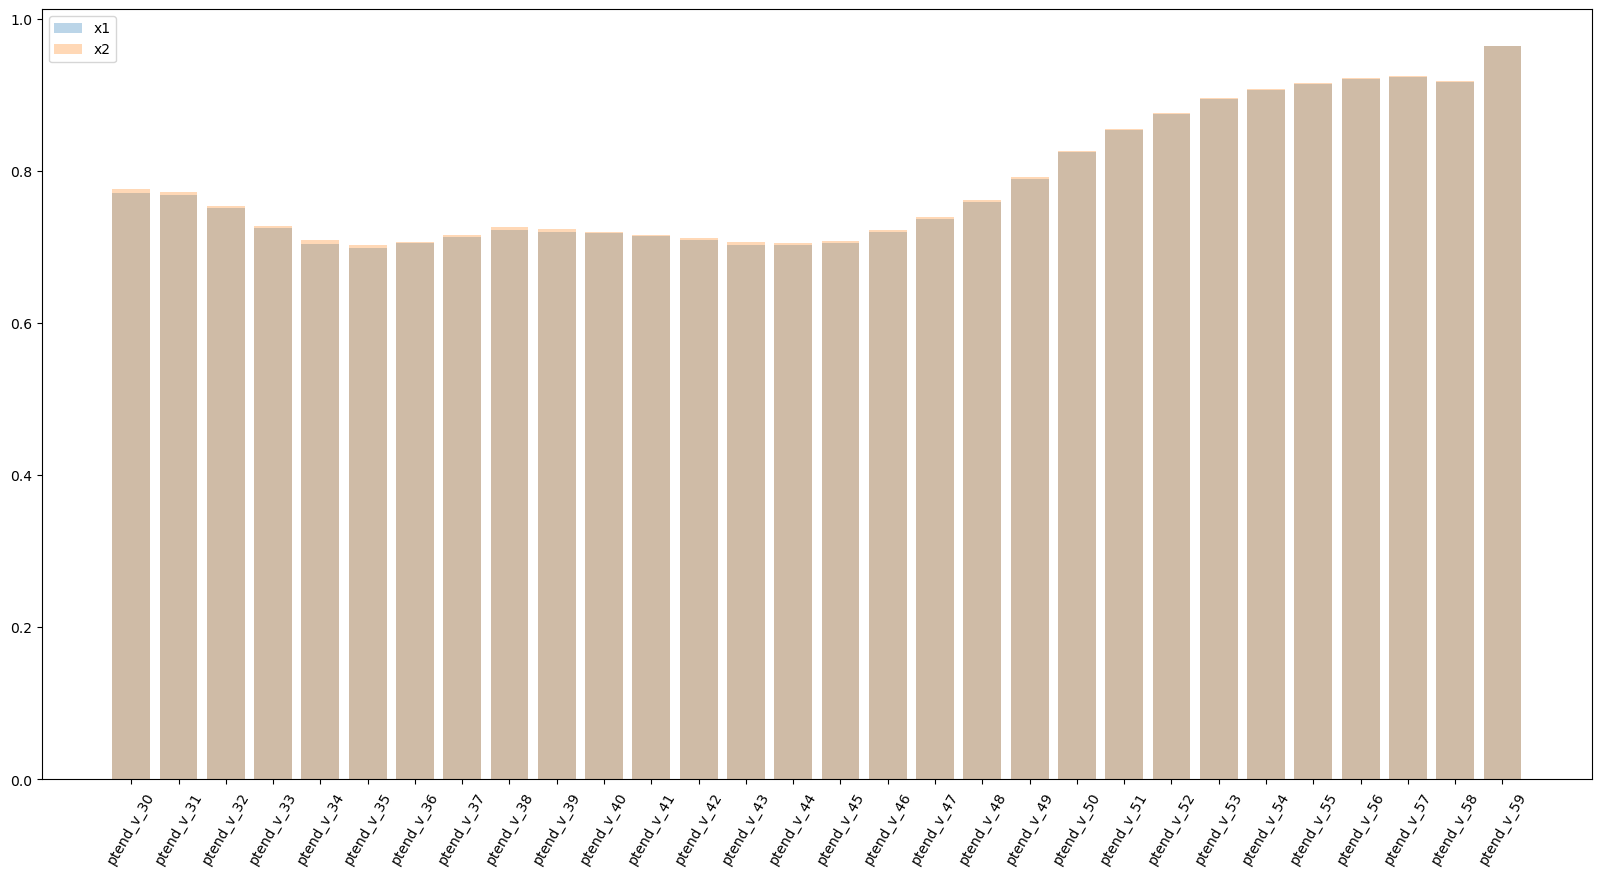

In [17]:
step = 30
plt.figure(figsize=(20, 10))
plt.bar(x1[:8], y1[:8], alpha=0.3)
plt.bar(x2[:8], y2[:8], alpha=0.3)
_ = plt.xticks(rotation=60)
plt.show()
for i in range(8, 360, step):
    plt.figure(figsize=(20, 10))
    plt.bar(x1[i:i+step], y1[i:i+step], alpha=0.3, label="x1")
    plt.bar(x2[i:i+step], y2[i:i+step], alpha=0.3, label="x2")
    _ = plt.xticks(rotation=60)
    plt.legend()
    plt.show()

## 検証データにおける性能分析

In [1]:
import pickle

import yaml
import polars as pl

In [2]:
df1 = pl.read_csv("../output/exp092a/run0/evaluation.csv")
df2 = pl.read_csv("../output/exp103a/run0/evaluation.csv")

In [19]:
def calc_diff(df, col):
    diff = (
        df
        .select(
            pl.col("sample_id_label").alias("sample_id"),
            pl.col(col),
            pl.col(f"{col}_label"),
            ((pl.col(col) - pl.col(f"{col}_label"))**2).alias("diff"),
        )
        .with_columns((pl.col("diff") / pl.col("diff").sum()).alias("diff_ratio"))
    )
    return diff

In [20]:
col = "ptend_q0002_35"
diff1 = calc_diff(df1, col)
diff2 = calc_diff(df2, col)

In [25]:
diff1[f"{col}"].describe(), diff2[f"{col}"].describe()

(shape: (9, 2)
 ┌────────────┬───────────┐
 │ statistic  ┆ value     │
 │ ---        ┆ ---       │
 │ str        ┆ f64       │
 ╞════════════╪═══════════╡
 │ count      ┆ 500139.0  │
 │ null_count ┆ 0.0       │
 │ mean       ┆ -0.024257 │
 │ std        ┆ 0.638743  │
 │ min        ┆ -19.03125 │
 │ 25%        ┆ -0.071045 │
 │ 50%        ┆ -0.001526 │
 │ 75%        ┆ 0.011688  │
 │ max        ┆ 15.640625 │
 └────────────┴───────────┘,
 shape: (9, 2)
 ┌────────────┬───────────┐
 │ statistic  ┆ value     │
 │ ---        ┆ ---       │
 │ str        ┆ f64       │
 ╞════════════╪═══════════╡
 │ count      ┆ 500139.0  │
 │ null_count ┆ 0.0       │
 │ mean       ┆ -0.019014 │
 │ std        ┆ 0.645974  │
 │ min        ┆ -18.375   │
 │ 25%        ┆ -0.069946 │
 │ 50%        ┆ -0.000877 │
 │ 75%        ┆ 0.014084  │
 │ max        ┆ 18.34375  │
 └────────────┴───────────┘)

In [26]:
diff1.sort("diff_ratio").tail(10)

sample_id,ptend_q0002_35,ptend_q0002_35_label,diff,diff_ratio
str,f64,f64,f64,f64
"""train_9537186""",-0.411865,16.605778,289.600172,0.001218
"""train_9525615""",-9.875,7.275703,294.146612,0.001237
"""train_9992848""",-0.585449,16.801651,302.311254,0.001272
"""train_9545323""",7.308594,24.704319,302.611257,0.001273
"""train_9716207""",-10.296875,7.139812,304.038053,0.001279
"""train_9843232""",2.287109,21.211897,358.147583,0.001506
"""train_9786401""",1.354492,20.6264,371.40643,0.001562
"""train_9966100""",-3.0,17.737144,430.029161,0.001809
"""train_9596010""",6.105469,28.534933,503.080871,0.002116


In [27]:
diff2.sort("diff_ratio").tail(10)

sample_id,ptend_q0002_35,ptend_q0002_35_label,diff,diff_ratio
str,f64,f64,f64,f64
"""train_9537186""",-0.15564,16.605778,280.945113,0.001186
"""train_9545323""",7.660156,24.704319,290.503484,0.001226
"""train_9525615""",-9.882812,7.275703,294.414653,0.001243
"""train_9992848""",-0.657227,16.801651,304.812406,0.001287
"""train_9572458""",4.636719,22.114342,305.467305,0.001289
"""train_9843232""",2.478516,21.211897,350.939574,0.001481
"""train_9786401""",1.230469,20.6264,376.202149,0.001588
"""train_9902318""",1.732422,23.401011,469.527734,0.001982
"""train_9966100""",-4.539062,17.737144,496.229397,0.002095


In [7]:
diff2.filter(pl.col("sample_id") == "train_9554537")

sample_id,ptend_q0002_27,ptend_q0002_27_label,diff,diff_ratio
str,f64,f64,f64,f64
"""train_9554537""",0.52002,-0.000091,0.270515,0.000994


In [10]:
diff2.sort("diff_ratio").tail(100)

sample_id,ptend_q0002_27,ptend_q0002_27_label,diff,diff_ratio
str,f64,f64,f64,f64
"""train_9953126""",-0.356201,0.002903,0.128956,0.000506
"""train_9729952""",0.362061,0.002903,0.128994,0.000506
"""train_9858637""",-0.356689,0.002903,0.129307,0.000507
"""train_9967900""",-0.35791,0.002903,0.130186,0.000511
"""train_9794871""",-0.359863,0.002903,0.131599,0.000516
…,…,…,…,…
"""train_9597867""",-0.874512,-2.160939,1.654895,0.006491
"""train_9548327""",-0.47168,-2.014525,2.380371,0.009337
"""train_9991831""",-1.608398,0.002903,2.596292,0.010183


In [13]:
diff1.filter(pl.col("sample_id") == "train_9597866")

sample_id,ptend_q0002_27,ptend_q0002_27_label,diff,diff_ratio
str,f64,f64,f64,f64
"""train_9597866""",-4.476562,-4.325198,0.022911,0.000097


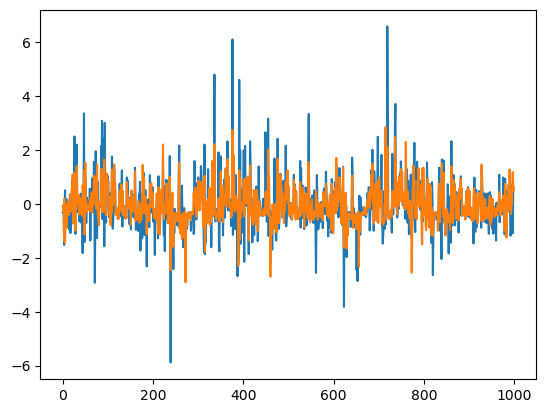

In [99]:
num_data = 1000
plt.plot(np.arange(num_data), df[f"{col}_label"].to_numpy()[:num_data])
plt.plot(np.arange(num_data), df[col].to_numpy()[:num_data])